# Examining the Jupyter contribution plateau

Jason asked about a plateau in contributions around 2016, which showed up in one of my slides. This notebook digs a little deeper into that to see if we can understand why.

First, load our dataset and plotting utilities

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%run utils.py

Load data processed from the raw event sources in [post-process-data](post-process-data.ipynb)

In [160]:
df = pd.read_feather("data/processed.feather")
df.head()

,type,repo_name,actor_id,actor_login,org,date
0,PushEvent,ipython/ipython,72162001,(no author)@5d925edf-2efb-0310-891d-d227fdbe9301,ipython,2003-03-02 04:28:20+00:00
1,PushEvent,ipython/ipython,57394,fperez,ipython,2003-03-02 04:28:20+00:00
2,PushEvent,ipython/ipython,57394,fperez,ipython,2003-03-02 04:28:21+00:00
3,PushEvent,ipython/ipython,72162001,(no author)@5d925edf-2efb-0310-891d-d227fdbe9301,ipython,2003-03-02 04:28:21+00:00
4,PushEvent,ipython/ipython,72162001,(no author)@5d925edf-2efb-0310-891d-d227fdbe9301,ipython,2003-03-02 05:13:27+00:00


If we look at annual total contributions by org, there is a plateu around 2016,
which Jason asked about in the chat.

Text(0.5, 1.0, 'Annual contributions by org')

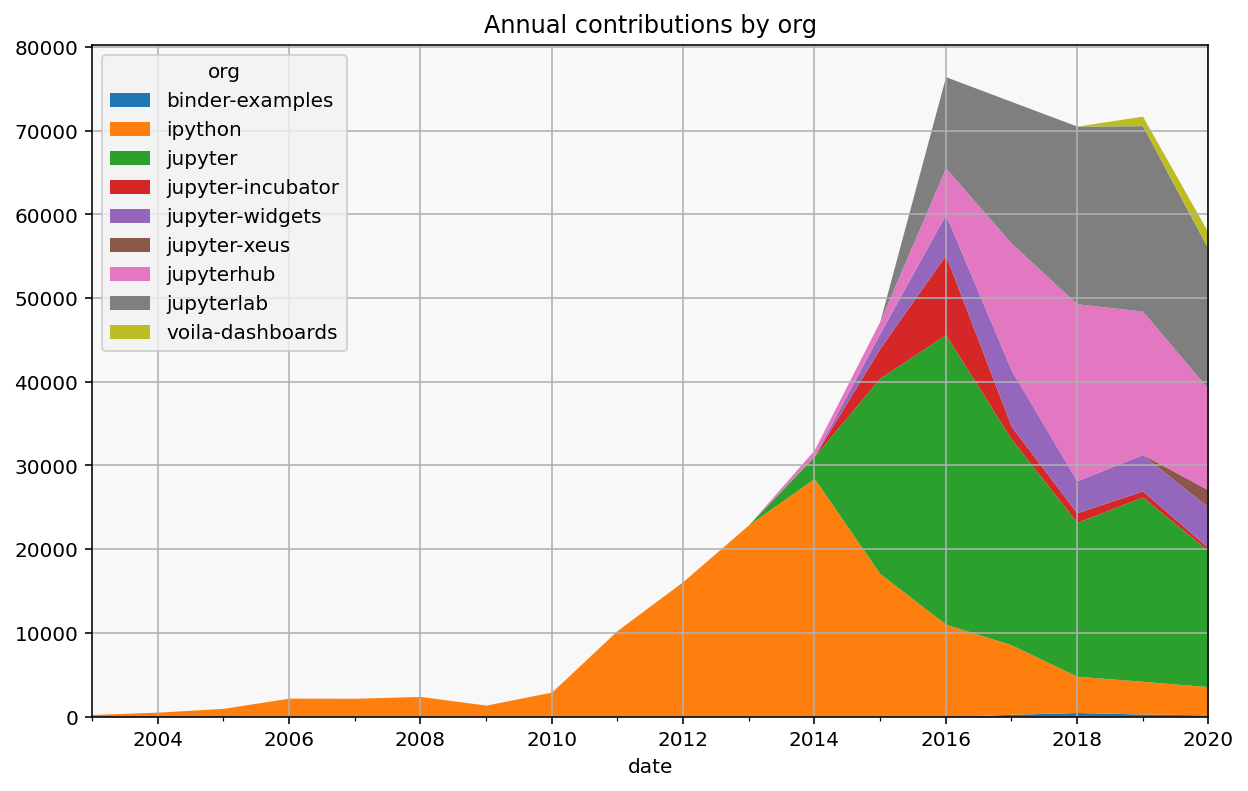

In [162]:
plot_events(df, groupby="org", timeseries=True, metric="count", freq="Y")
plt.title("Annual contributions by org")

If we switch to the *unique* contributors per year metric, it's still rising (if slowing a bit),
with a drop in 2020, which has been an exceptional year and we only have data for the first 9 months anyway.

Text(0.5, 1.0, 'Annual *unique* contributions by org')

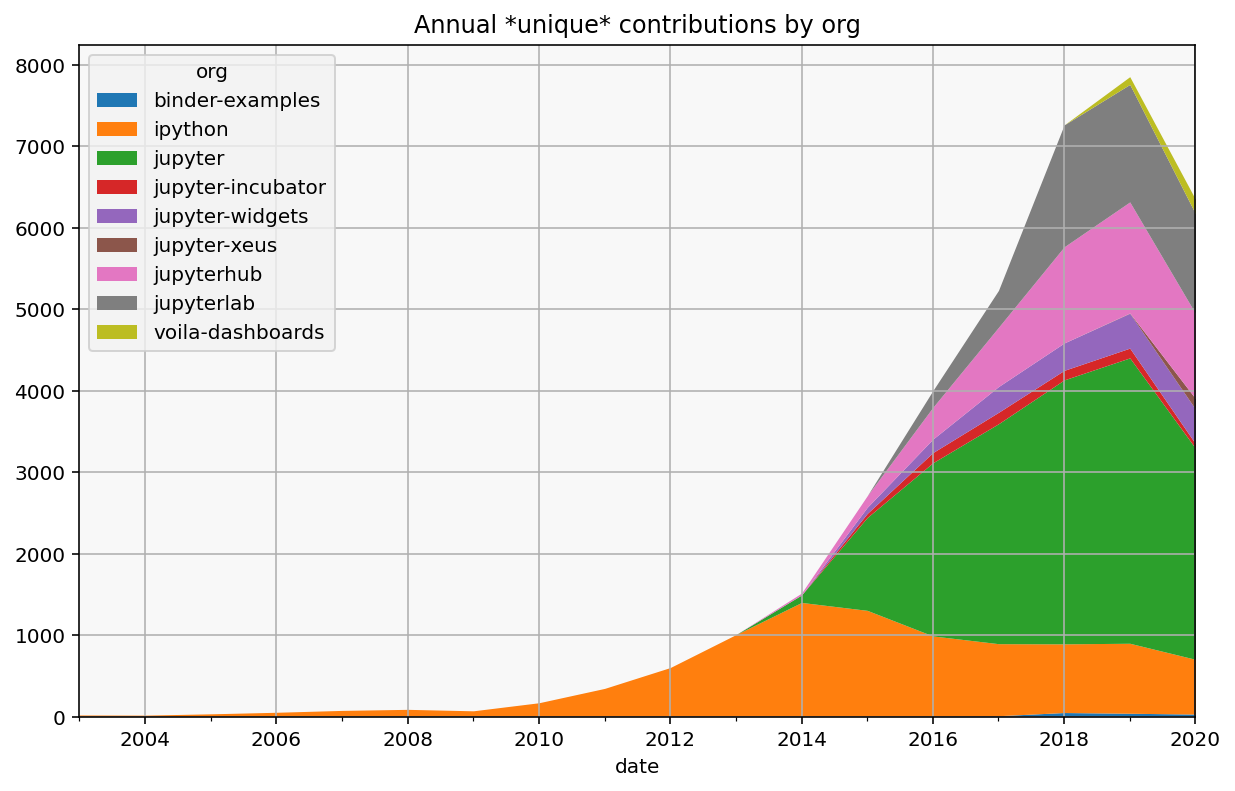

In [163]:
plot_events(df, groupby="org", timeseries=True, metric="nunique", freq="Y")
plt.title("Annual *unique* contributions by org")

## How many contributions come from contributors with how many people

For some of us, working on Jupyter is our job,
which means we have a lot more time to discuss Issues, open Pull Requests, and push changes.
Others might only have the occasional night or weekend free,
while still others might only have their one Issue to report.

How does the community distribute into these groups?

25037 total unique contributors


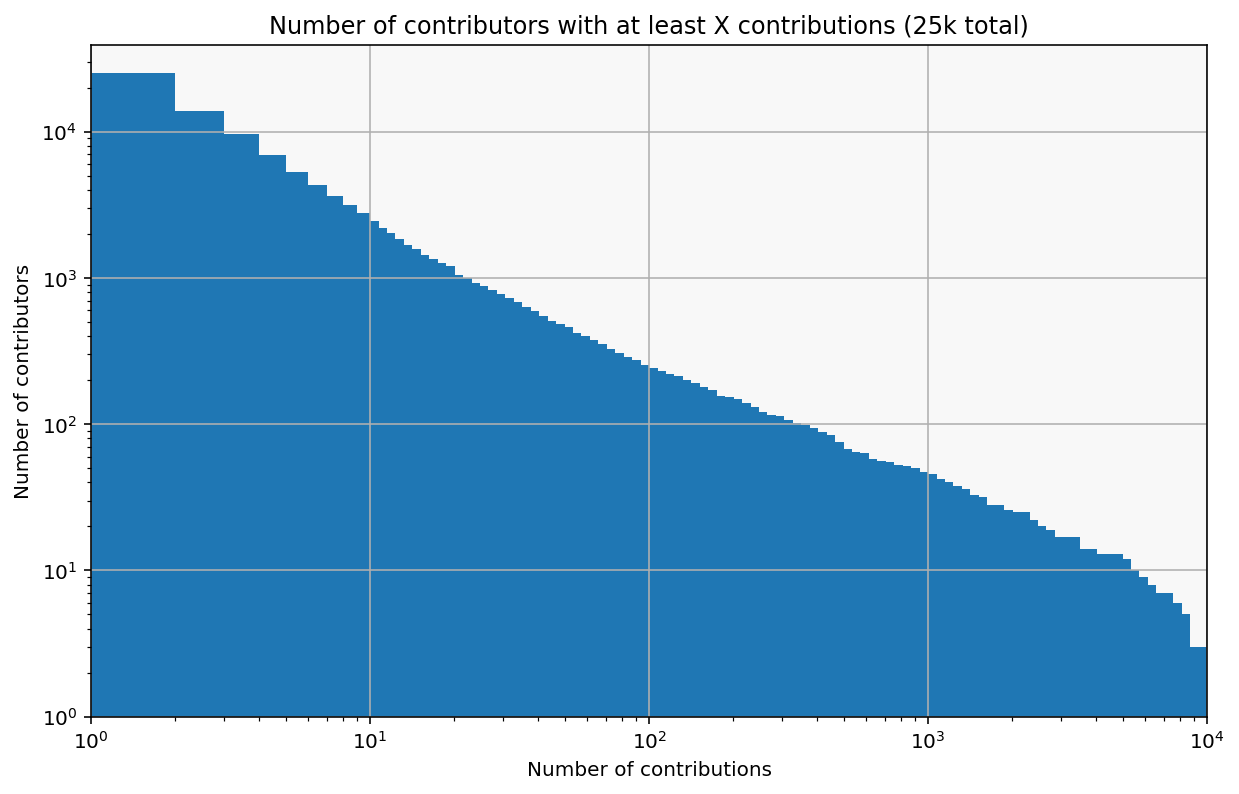

In [165]:
from itertools import chain

bins = list(chain(range(10), np.logspace(1, 4, 100)))
counts, _ = np.histogram(df.actor_id.value_counts(), bins=bins)
counts[:5]

fig, ax = plt.subplots()
hist = df.actor_id.value_counts().plot(
    kind="hist",
    bins=bins,
    ax=ax,
    cumulative=-1,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Number of contributors")
ax.set_xlabel("Number of contributions")
ax.set_title(f"Number of contributors with at least X contributions ({df.actor_id.nunique()//1000}k total)")

ax.set_xlim(1, 10000)
ax.set_ylim(1, None)
print(f"{df.actor_id.nunique()} total unique contributors")

Rescaling to a fraction shows that ~90% of contributors
have contributed to the conversation fewer than 10 times.

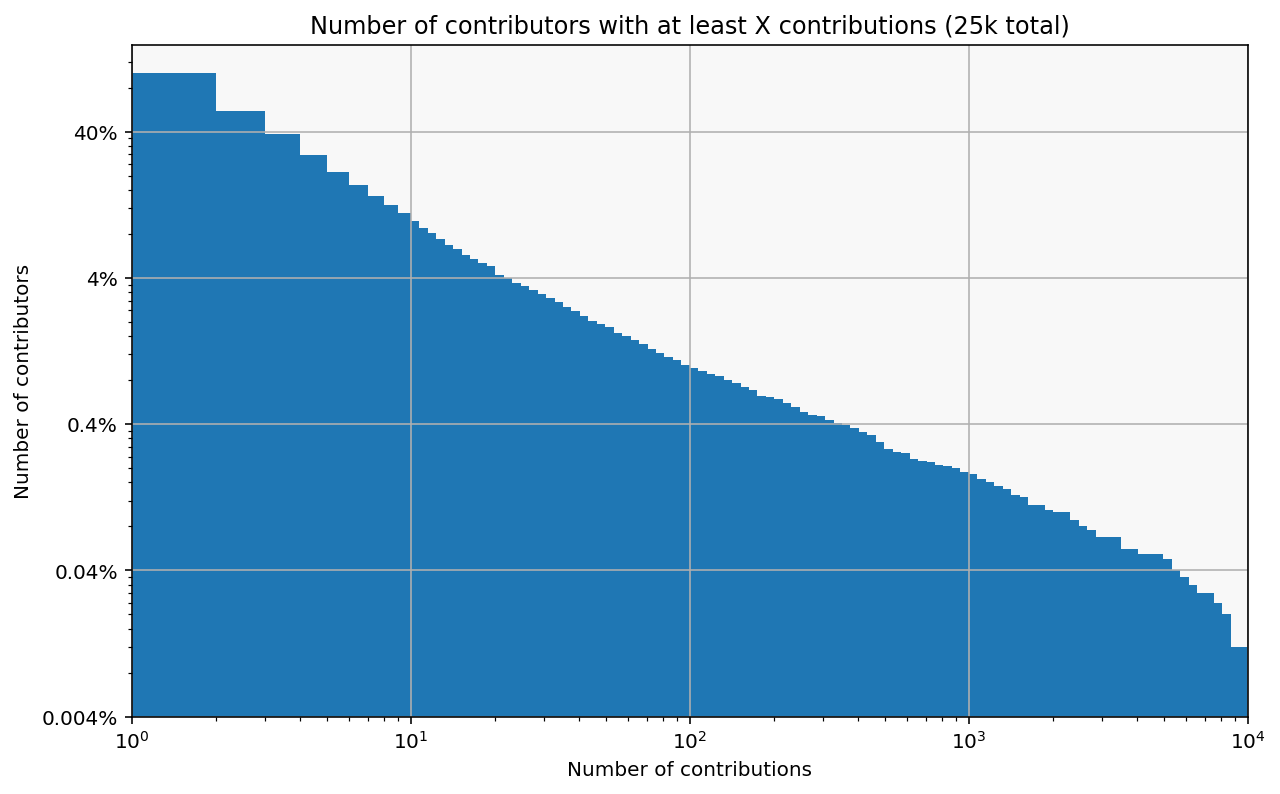

In [33]:
from matplotlib import ticker as tick

def adjust_y_axis(x, pos):
    return f"{100 * x / (len(df.actor_id.unique())):.2g}%"

ax.yaxis.set_major_formatter(tick.FuncFormatter(adjust_y_axis))
display(ax.figure)

## Annual contributions from frequent contributors

We can try to break-down the annual contributions into groups,
top 5 contributors, top 10 excluding top 5, top 50 excluding top 10, and so forth.

This will allow us to see what are the primary contributors to the activity plateau.
Is it driven by a pleateau in audience, or are the most-active folks less active?

These exclusions allow us to do cumulative sums / stacked charts later on,
as the cumulative sum across a given row gives totals with no double-counted groups.

In [38]:
by_year = df.groupby(df.date.dt.year)
top_contributors_by_year = by_year.actor_id.value_counts()
top_contributors_by_year

date  actor_id
2003  57394       187
      72162005     29
      72162001      6
      72162013      5
      72162017      5
                 ... 
2020  72165242      1
      72165243      1
      72165244      1
      72165245      1
      72165246      1
Name: actor_id, Length: 32687, dtype: int64

In [131]:
levels = [5, 10, 50, 100]
columns = ["year"] + [f"top {n}" for n in levels] + ["rest"]
rows = []

years = years = sorted(df.date.dt.year.unique())
for year_dt, idx in by_year.groups.items():
    events = df.loc[idx]
    row = [year_dt.year]
    tops = top_contributors_by_year[year_dt.year].index
    n_prev = Nonema
    for n in levels:
        mask = events.actor_id.isin(tops[:n])
        if n_prev:
            mask = mask & ~events.actor_id.isin(tops[:n_prev])
        n_prev = n
        row.append(events[mask].actor_id.count())
    row.append(events[~events.actor_id.isin(tops[:n])].actor_id.count())
    rows.append(row)
counts_by_year = pd.DataFrame(rows, columns=columns)
counts_by_year = counts_by_year.set_index("year")
counts_by_year

,top 5,top 10,top 50,top 100,rest
year,,,,,
2003,232,11,10,0,0
2004,480,35,17,0,0
2005,682,214,90,0,0
2006,1558,383,266,3,0
2007,1532,296,331,29,0
2008,1363,492,494,57,0
2009,857,241,255,21,0
2010,1820,331,585,128,70
2011,6983,1050,1372,407,486


The same table as percentages (cumulative this time)

In [186]:
total = counts_by_year.cumsum(axis=1)["rest"]
fractions = counts_by_year.cumsum(axis=1)
(fractions.div(total, axis=0)).style.format("{:,.0%}")

,top 5,top 10,top 50,top 100,rest
year,,,,,
2003,92%,96%,100%,100%,100%
2004,90%,97%,100%,100%,100%
2005,69%,91%,100%,100%,100%
2006,70%,88%,100%,100%,100%
2007,70%,84%,99%,100%,100%
2008,57%,77%,98%,100%,100%
2009,62%,80%,98%,100%,100%
2010,62%,73%,93%,98%,100%
2011,68%,78%,91%,95%,100%


We can plot each group individually to see how their contributions have grown over time

remember, top 10 is really 6-10, top 50 is really 11-50, etc.

Text(0.5, 1.0, 'Contributions from each slice')

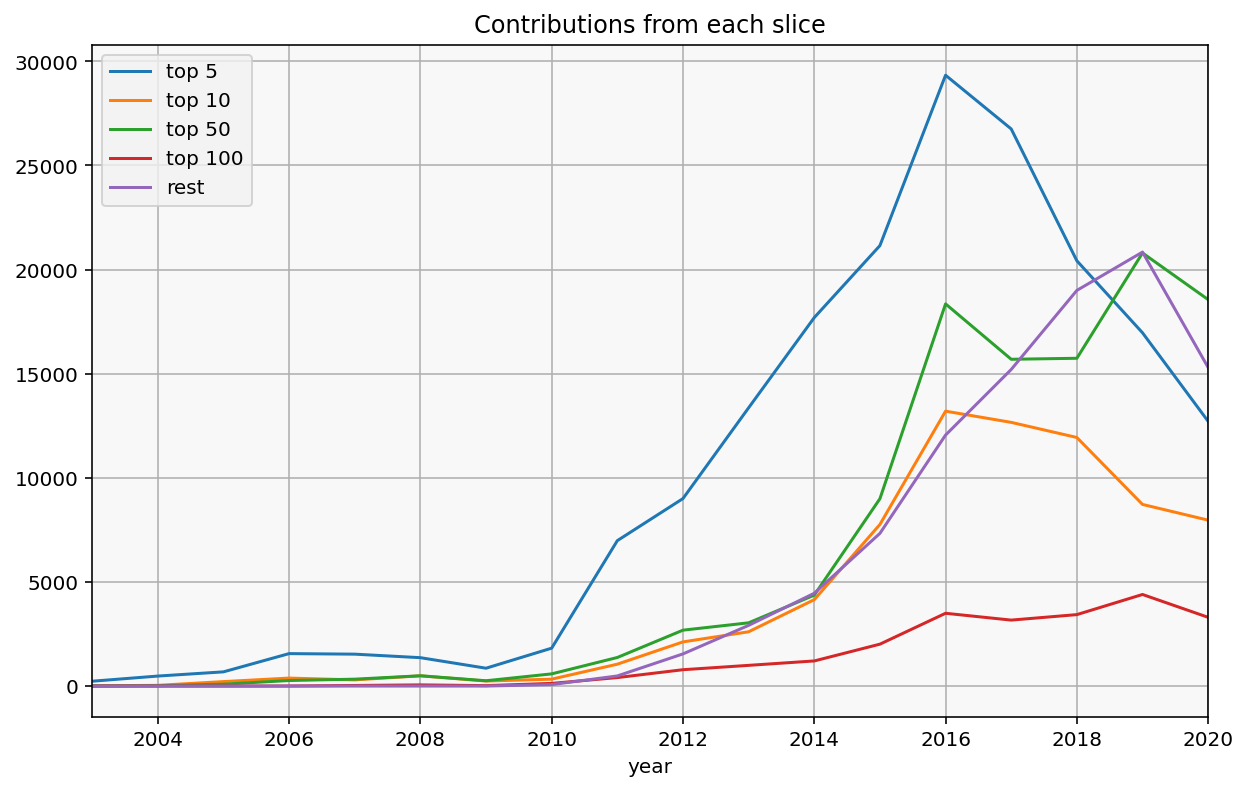

In [137]:
counts_by_year.plot()
plt.xlim(2003,2020)
plt.title("Contributions from each slice")
# plt.xticks(counts_by_year.index[::2]);

We see a *huge* drop in activity from the top 5 contributors

The same data as a stacked bar chart, showing cumulative sums,
we can see how each changes.

It's a little harder to see individual slopes in this one due to the stacking.

(2003.0, 2020.0)

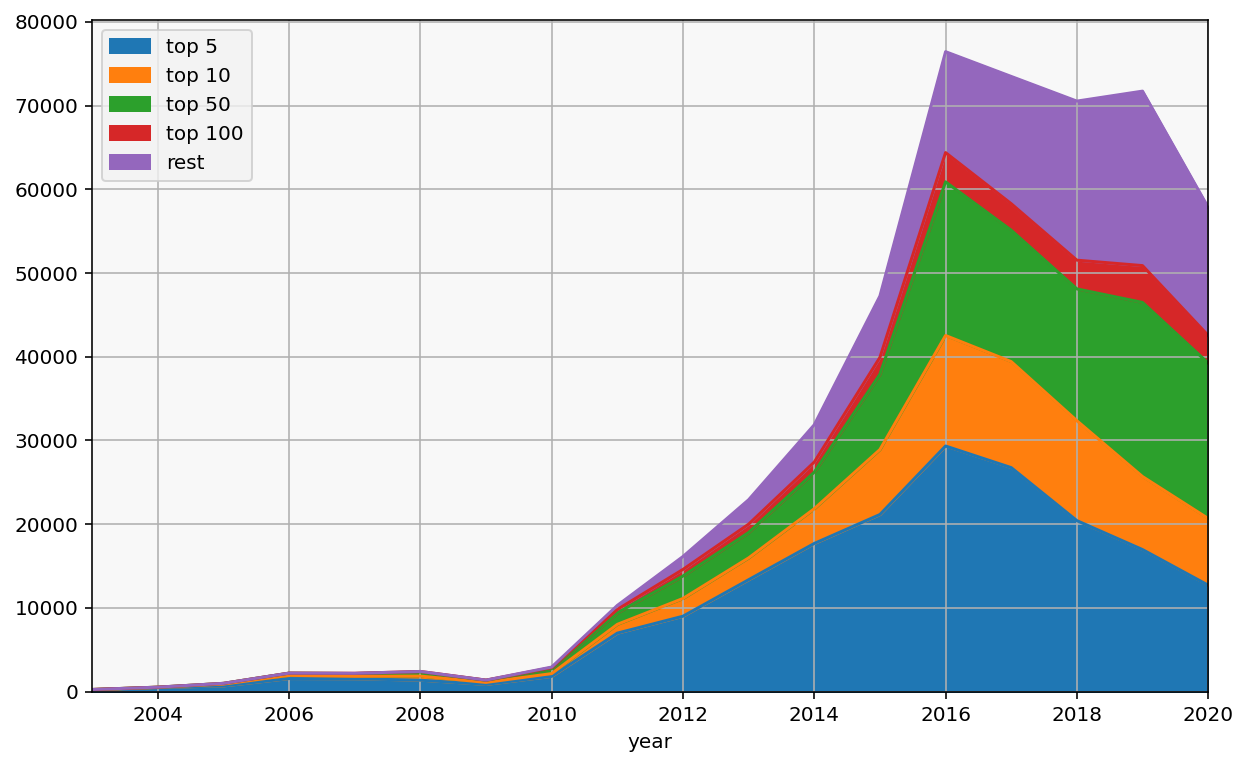

In [187]:
# reverse column order so that 'rest' is at the b
counts_by_year.plot.area()
plt.xlim(2003, 2020)

(2003.0, 2020.0)

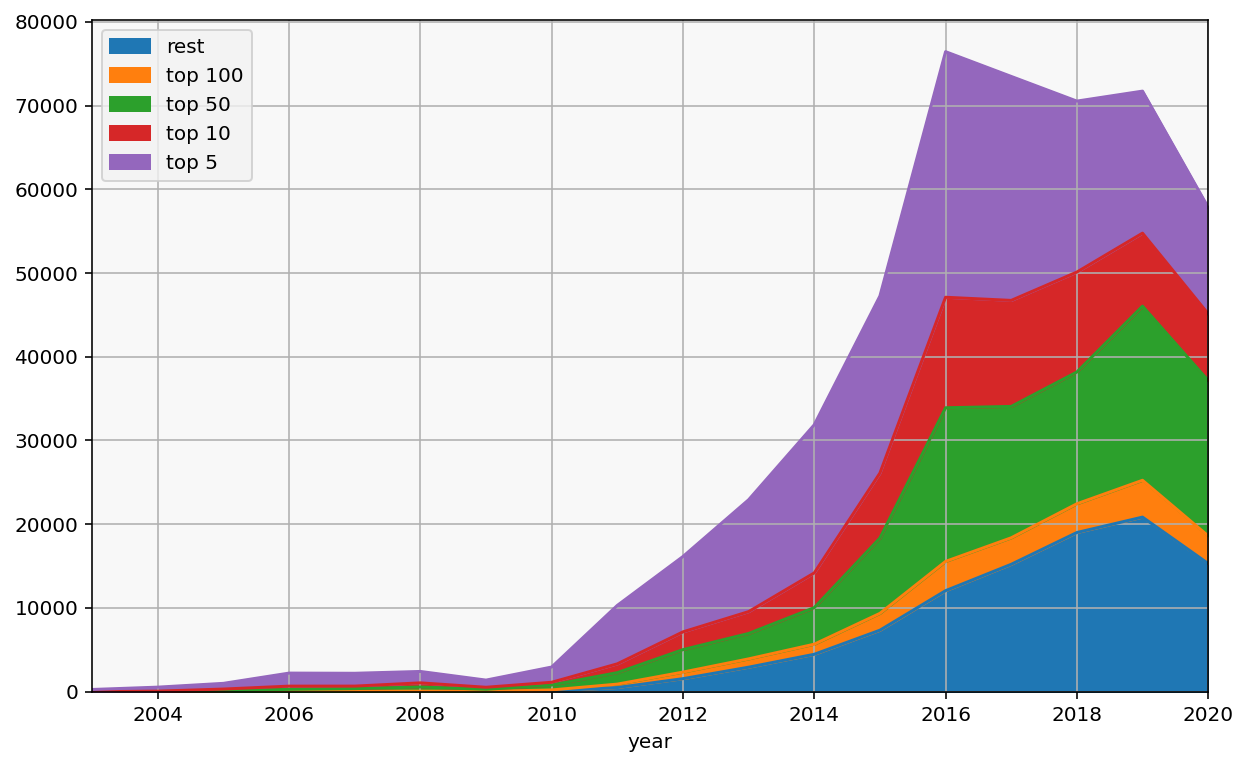

In [136]:
# reverse column order so that 'rest' is at the b
counts_by_year[counts_by_year.columns[::-1]].plot.area()
plt.xlim(2003, 2020)

Key data points:

- in 2016, 5 contributors accounted for 38% of activity. In 2019, this was 24%
- total activity from top 5 contributors in 2016 exceeded that of the top 10 contributors in 2019
- top 10 contributors in 2016 contributed almost as much as top 50 in 2019
- contributions from outside top 100 continue to grow steadily


Not counting 2020, the contribution plateau can be ascribed almost entirely to a drop in activity from the top 5-10 contributors. "outside" contributions, i.e. folks who contribute less than the top 100 in any given year, are continuing to rise linearly through 2019 (if not exponentially, as seen up to 2016).


I think we can conclude that the plateau in total activity is ascribed primarily to two factors:

1. a drop in activity from a very small number of highly active (mainly full-time, paid) contributors
2. failure to grow the active/professional 'core' maintainers of the project to fill that gap

Of course, the relative contributions the top 5 number *should* drop or at least flatten as we develop the community into having more members with a 'maintainer' role. And speaking as one of those five in 2016, the absolute value should also drop. We used to have only a few folks who answered ~every GitHub issue and that was never going to be sustainable. This has spread out, as it should. However, since we know the wider activity *is* rising, I think we can probably say that we aren't doing *enough* expansion of maintainer capacity, and can do more community and/or funding work to expand our "maintainer" base to keep up with the community.

Note: some of these drops may or may not mean a drop in actual activity, but rather a drop in *measured* activity. This isn't a complete dataset, and activity in other places, such as the discourse forum, online meetings, conferences, etc. are not counted.

The data here is a *very rough* proxy for actual activity and contributions, and to first order is really just the GitHub comment frequency, which dwarfs any other source of events.